# 1. Startup Application and Internal Memory 

In [4]:
!pip install -r requirements.txt --quiet

In [6]:
import pickle
import pandas as pd
import hopsworks
import os

from keys import TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3
from TomTomAPI import get_traffic_map, plot_traffic_map, get_grid_from_map, get_traffic_map_from_grid, get_grid_from_map_alt
from HolidaysnWeather import get_weather, is_holiday

/Users/diogosilva/Documents/Scalable ML and DeepL/Project-ID2223_TrafficApp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coordinates = 59.34318, 18.05141 # Stockholm near Odenplan
radius = 1000
zoom = 20

TOMTOM_keys = [TOMTOM_API_KEY, TOMTOM_API_KEY2, TOMTOM_API_KEY3]

### 1.1. Create GRID for extracting traffic data

In [3]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map = get_traffic_map(TOMTOM_keys[i], coordinates, radius, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

eliminated: 7
eliminated: 3
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
eliminated: 2
eliminated: 2
eliminated: 1
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}
{'error': 'Point too far from nearest existing segment.', 'httpStatusCode': 400, 'detailedError': {'code': 'INVALID_REQUEST', 'message': 'Point too far from nearest existing segment.'}}


1145
298


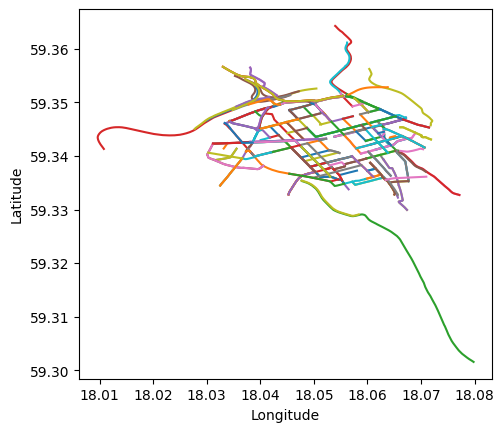

In [4]:
print(len(traffic_map))
traffic_map = set([str(s) for s in traffic_map])
traffic_map = [eval(s) for s in list(traffic_map)]
print(len(traffic_map))

plot_traffic_map(traffic_map)

In [5]:
grid = get_grid_from_map_alt(traffic_map)

with open('variables/grid.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(grid, file)

### 1.2. Collect traffic data

Failed with key: zJT5UBCDtRKSWwsbGp6LWjcQcIi0IcdV
num of requests: 298
298
180


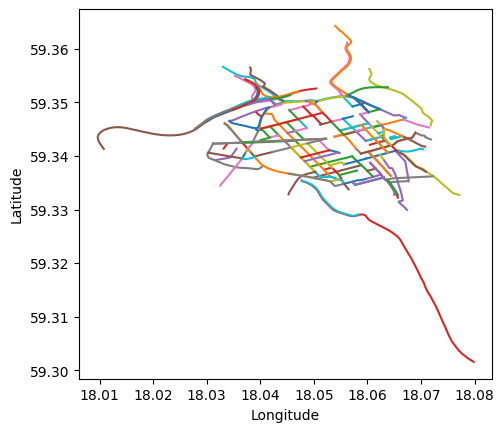

In [ ]:
success = False
i = 0
while i < len(TOMTOM_keys) and not success:
    try:
        traffic_map2 = get_traffic_map_from_grid(TOMTOM_keys[i],grid, zoom = zoom)
        success = True
    except:
        print('Failed with key:', i)
        i += 1

print(len(traffic_map2))
traffic_map2 = set([str(s) for s in traffic_map2])
traffic_map2 = [eval(s) for s in list(traffic_map2)]
print(len(traffic_map2))

plot_traffic_map(traffic_map2, name = 'figures/traffic_map2.png')

In [12]:
from shapely.geometry import LineString
import datetime

traffic_df = pd.DataFrame(traffic_map)
traffic_df['coordinates'] = traffic_df['coordinates'].apply(lambda x: LineString([(point['longitude'], point['latitude']) for point in x['coordinate']]))
traffic_df = traffic_df.drop_duplicates()

today = datetime.datetime.now()
dates = [today for i in range(traffic_df.shape[0])]
multi_index = pd.MultiIndex.from_arrays(
    [dates,traffic_df['frc'], traffic_df['coordinates']],  # Pass as a list of arrays
    names=['date','frc', 'coordinates']  # Assign level names
)
traffic_df.index = multi_index

traffic_df = traffic_df.drop(columns = ['@version','frc', 'coordinates'])

print(traffic_df.shape)
traffic_df.head(1)

(298, 6)


,,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,confidence,roadClosure
frc,coordinates,,,,,,
FRC6,"LINESTRING (18.05304761930674 59.33612019924765, 18.052956424200204 59.33624626218505, 18.05288936897483 59.33634150372781, 18.052741847478956 59.336566782256796, 18.05265199347693 59.336659329834355, 18.0520189921493 59.33727625024616, 18.05198948785008 59.33730442005571, 18.051886222803006 59.33741974932061, 18.05185805960835 59.33744924414018, 18.050928674184462 59.33839203896625, 18.04989736481798 59.3394354262025, 18.049815557443026 59.339518562397586, 18.049217424832563 59.34013278083443, 18.04913561745761 59.34021728308633, 18.047573230706064 59.34179577386307, 18.047361336193802 59.342010331133054)",15,21,175,125,0.92,False


### 1.3. Collect weather data

In [8]:
weather_df = get_weather(coordinates)
weather_df

,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2024-12-17,3.876,-0.024,0.0,33.48,279.494843


### 1.4. Collect weather data

In [9]:
holiday_status = is_holiday()
weather_df['holiday_status'] = holiday_status
weather_df

0

### 1.5. Joining data and uploading to Hopsworks

In [14]:
# Get the API key from GitHub Secrets
# HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')
from keys import HOPSWORKS_API_KEY

# Get AQI API KEY from secrets of hopsworks
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY
proj = hopsworks.login(project="ID2223LAB1KTH")

2024-12-17 16:38:12,795 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-17 16:38:12,802 INFO: Initializing external client
2024-12-17 16:38:12,803 INFO: Base URL: https://c.app.hopsworks.ai:443


ProjectException: Could not find project ID2223LAB1KTH

In [ ]:
# Initialize the feature store
fs = proj.get_feature_store()

# Define and insert the Forecast Weather Feature Group
feature_group_name = "stockholm_traffic"
version = 1
fg = fs.get_or_create_feature_group(name=feature_group_name, version=version)
fg.insert(traffic_df)

# Define and insert the Air Quality Feature Group
feature_group_name = "stockholm_weather&holiday"
version = 1
fg = fs.get_or_create_feature_group(name=feature_group_name, version=version)
fg.insert(weather_df)